In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# Fetch LFW dataset with minimum faces per person = 40
lfw_people = fetch_lfw_people(min_faces_per_person=40, resize=0.4)
# Extracting data and target labels
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
# df = np.genfromtxt('./lfw_people.csv',delimiter=',')
# X = df[:, :-1]
# y = df[:, -1]
n_samples, n_features = X.shape
n_classes = len(np.unique(y))

# Print dataset statistics
print("Number of samples: %d" % n_samples)
print("Number of features: %d" % n_features)
print("Number of classes: %d" % n_classes)

Number of samples: 1777
Number of features: 1850
Number of classes: 17


## Building a PCA class

In [3]:
class PCA:
  def __init__(self,n_components=None):
    # To initialize a PCA object

    # Total number of reduced features in projected data
    self.n_components = n_components
    self.eigenvalues = None
    self.eigenvectors=None
    self.means=None

  def fit(self,X):
    # To fit the model and finding principal components given an array X.
    if self.n_components==None:
      self.n_components=X.shape[0]
    self.means = np.mean(X,axis=0)
    X_mean = X-self.means
    cov_matrix = (X_mean.T @ X_mean)/X_mean.shape[0]
    cov_matrix = (cov_matrix + cov_matrix.T)/2
    self.eigenvalues, self.eigenvectors = np.linalg.eig(cov_matrix)
    self.eigenvalues = np.abs(np.real(self.eigenvalues))
    self.eigenvectors = np.real(self.eigenvectors)

    # (v) Sort eigenvectors based on eigenvalues
    # print(eigenvalues[eigenvalues<0])
    sorted_indices = np.argsort(self.eigenvalues)[::-1]
    self.eigenvalues = self.eigenvalues[sorted_indices]
    self.eigenvectors = self.eigenvectors[:, sorted_indices]
    self.eigenvectors = self.eigenvectors/np.sqrt((np.sum(self.eigenvectors*self.eigenvectors, axis=0)))
    return X @ self.eigenvectors[:,:self.n_components]

  def fit_transform(self,X):
    # returns the given array after projected it along principal components
    return X @ self.eigenvectors[:,:self.n_components]


  def explained_variance(self):
    # returns first 'n_components' number of eigen values in decreasing order
    return self.eigenvalues[:self.n_components]
  def explained_variance_ratio(self):
    # returns ratio of variance captured by first 'n_components' number of eigen values in decreasing order
    return self.eigenvalues[:self.n_components]/np.sum(self.eigenvalues)

  def components(self):
    # returns principal components
    return self.eigenvectors[:,:self.n_components]

  def get_eigenvalues(self):
    # returns all eigen values
    return self.eigenvalues
  def get_eigenvectors(self):
    # returns all eigenvectors
    return self.eigenvectors

### PCA implementation

In [4]:
# To perform splitting of data into train and test sets with ratio 80:20
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
num_components=192   # To reduce the data into 200 features.
# To apply PCA on train data and get principal components.
pca = PCA(n_components=num_components)
X_projected = pca.fit(X_train)
X_test_projected = pca.fit_transform(X_test)
principal_components = pca.components()
# Convert principal components back to eigen faces.
eigenfaces = (principal_components.T).reshape((principal_components.shape[1],50,37))

# Reconstruct the original data from the extracted features.
X_reconstructed = (X_projected @ (principal_components.T))

### Explained Variance ratio

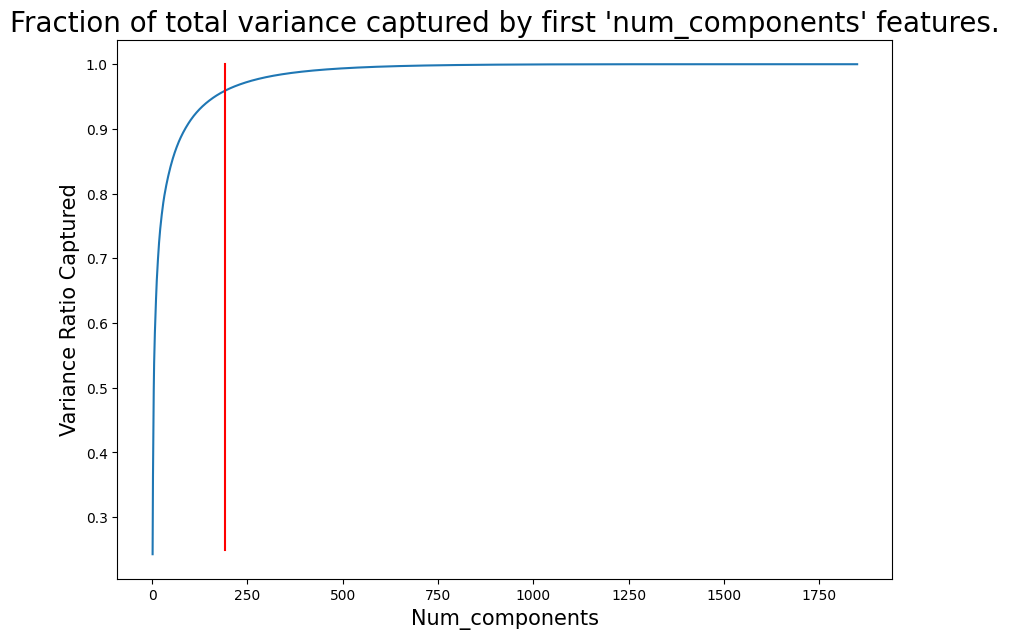

In [5]:
# To plot the graph of total variance captured by first 'num_components' eigen vectors.
x = np.arange(1,1851,1)
y = np.cumsum(pca.get_eigenvalues())/np.sum(pca.get_eigenvalues())
plt.figure(figsize=(10,7))
plt.plot(x,y)

x = [num_components,num_components]
y = [0.25,1]
plt.plot(x,y,'r')
plt.title("Fraction of total variance captured by first 'num_components' features.",size=20)
plt.xlabel("Num_components",size=15)
plt.ylabel("Variance Ratio Captured",size=15)
plt.show()

### Eigen Faces

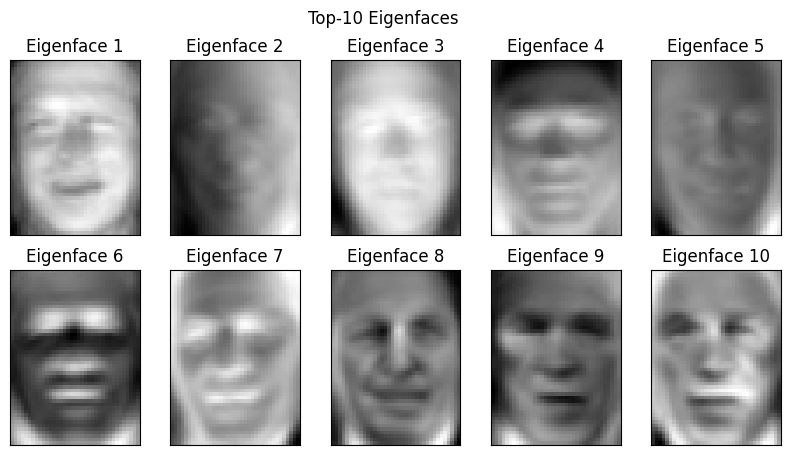

In [6]:
# To plot the first 10 eigenfaces
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(eigenfaces[i], cmap='gray')
    plt.title(f"Eigenface {i + 1}")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("Top-10 Eigenfaces")
plt.show()

### Reconstructed face data

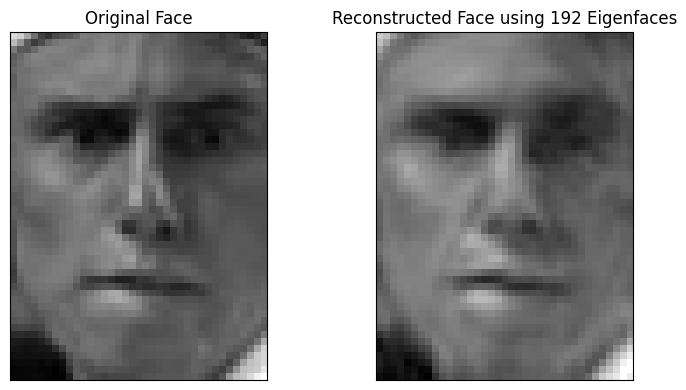

In [7]:
og_face0 = X_train[0].reshape((50,37))
reconstructed_face0 = X_reconstructed[0].reshape((50,37))
# Plot the original and reconstructed faces
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(og_face0, cmap='gray')  # Reshape to original shape before plotting
plt.title('Original Face')
plt.xticks(())
plt.yticks(())

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_face0, cmap='gray')
plt.title(f'Reconstructed Face using {num_components} Eigenfaces')
plt.xticks(())
plt.yticks(())

plt.tight_layout()
plt.show()

In [8]:
class LDAclass:
    def __init__(self, n_components):
        self.n_components = n_components
    def fit_transform(self,X_train,Y_train):
        #X_train = X_train.T
        overall_mean = np.mean(X_train, axis=0)

        Sw = np.zeros((X_train.shape[1], X_train.shape[1]))
        Sb = np.zeros((X_train.shape[1], X_train.shape[1]))
        for i in np.unique(Y_train):
            class_indices = np.where(Y_train == i)[0]
            class_data = X_train[class_indices,:]
            class_mean = np.mean(class_data, axis=0)
            class_mean_diff = class_data - class_mean
            Sw += class_mean_diff.T @ class_mean_diff

        overall_mean_diff = X_train-overall_mean
        Sb = overall_mean_diff.T @ overall_mean_diff
        Sb-=Sw

        eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw) @ Sb)
        eigenvalues = np.real(eigenvalues)
        eigenvectors = np.real(eigenvectors)
        eigenvectors = eigenvectors/np.sqrt(np.sum(eigenvectors*eigenvectors))
        #eigenvectors = eigenvectors/(np.sum(eigenvectors*eigenvectors,axis=0))

        sorted_indices = np.argsort(np.abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
# Only the first 6 eigenvalues have significance. Remaining values are close to zero compared to first six eigenvalues.

        self.principal_components = eigenvectors[:, :self.n_components]
        X_projected = X_train @ self.principal_components
        print(eigenvalues[:10])
        return X_projected

    def transform(self,X):
        return X @ self.principal_components

    def fischerfaces(self):
        return ((self.principal_components.T).reshape((self.principal_components.shape[1],16,12)))

[3.04987326 2.09231393 1.47617345 1.36921    1.15928058 1.00301376
 0.87632877 0.82400655 0.65192171 0.51908937]


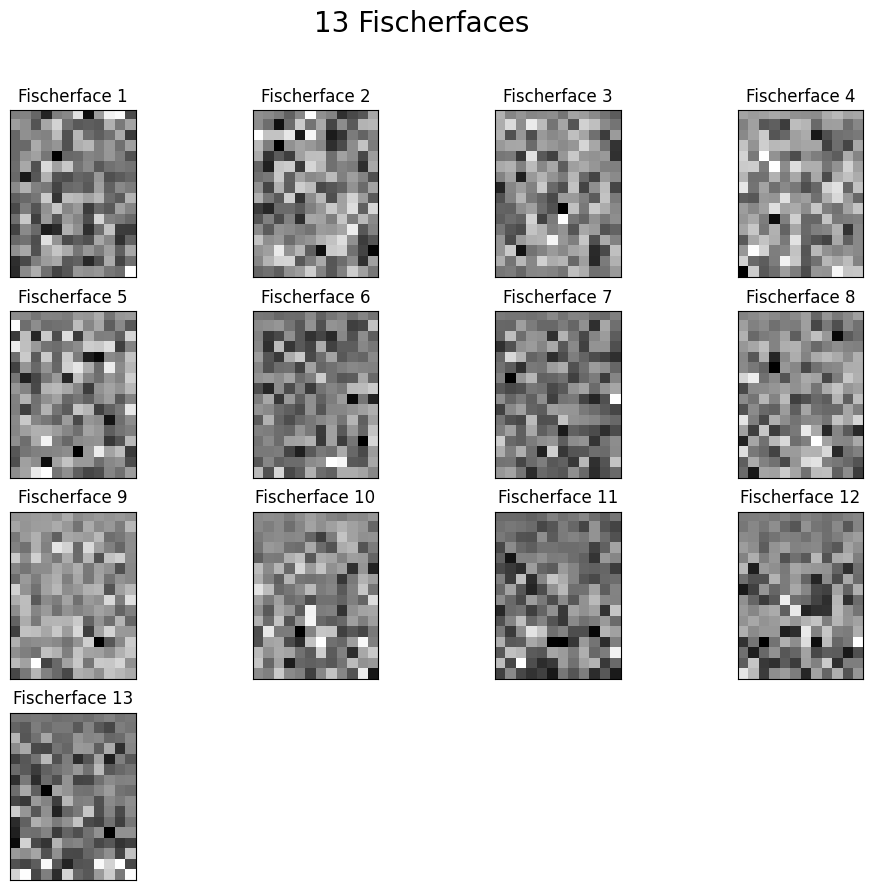

In [13]:
X_projected = X_train @ principal_components
X_test_projected = X_test @ principal_components
n_components=len(np.unique(Y_train)) - 1
lda = LDAclass(n_components = n_components)
X_projected = lda.fit_transform(X_projected, Y_train)
X_test_projected = lda.transform(X_test_projected)
fischerfaces = lda.fischerfaces()
plt.figure(figsize=(12,10))
for i in range(n_components-3):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fischerfaces[i], cmap='gray')
    plt.title(f"Fischerface {i + 1}")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("13 Fischerfaces",size = 20)
plt.show()